In [ ]:
library(sicegar)
library(dplyr)
library(tibble)
library(tidyr)
library(readr)
library(stringr)
library(purrr)
library(here)
library(lubridate)
library(ggplot2)
library(scales)



# Data Import and Preparation

We are working with 21 years of data 2000-2020, 14 stations and 3 species leading to a total of 882 data sets.

In [ ]:
pollen_daily <- read_delim(paste0(here(), "/data/dwh/pollen_dwh_daily.txt"), delim = " ", skip = 17, trim_ws = TRUE)
pollen_daily %<>% 
    mutate(across(is.numeric, ~ if_else(. < 0, NA_real_, .)),
    datetime = ymd_hm(paste0(YYYY, "-", sprintf("%02d", MM), "-", sprintf("%02d", DD), " ", sprintf("%02d", HH), ":", sprintf("%02d", mm))),
    year = year(datetime)) %>%
    filter(year <= 2020) %>%
    select(-(YYYY:mm)) %>%
    setNames(tolower(names(.))) %>%
    pivot_longer(plo:pcf, names_to = "station", values_to = "conc")

pollen_split <- pollen_daily %>%
    split(list(.$year, .$station, .$parameter))

larger_ten <- function(x) x > 0
season_start <- map(pollen_split, ~detect_index(replace(.x$conc, is.na(.x$conc), 0), larger_ten))
season_end <- map(pollen_split, ~detect_index(replace(.x$conc, is.na(.x$conc), 0), larger_ten, .dir = "backward"))


In [ ]:
pollen_season <- pmap(list(pollen_split, season_start, season_end), ~
  ..1 %>%
    slice(..2:..3) %>%
    rowid_to_column("day")) 

# This takes 100sek, wondering whether there is a more efficient solution
pollen_join <- pollen_season %>% bind_rows()

In [ ]:
pollen_mean_species <- pollen_join %>%
  group_by(day, parameter, station) %>%
  summarise(conc = mean(conc, na.rm = TRUE)) %>%
  ungroup %>%
  split(.$parameter)


## Timeseries 

this too

In [ ]:
map(pollen_mean_species, ~
    ggplot(.x, aes(x = day, y = conc, col = station, fill = station)) +
    geom_col() +
    ggtitle(paste("Average Daily", unique(.x$parameter), "Pollen Concentrations for the years 2000-2020")))

In [ ]:
pollen_sum_day <- map(pollen_mean_species, ~ .x %>%
  group_by(day, parameter) %>%
  summarise(conc = sum(conc, na.rm = TRUE)) %>%
  ungroup %>%
  mutate(conc = rescale(conc)) %>%
  select(time = day, intensity = conc))



name,value
<chr>,<chr>
finalAsymptoteIntensityRatio_N_Estimate,0.0218411932599301
finalAsymptoteIntensityRatio_Std_Error,0.0034843553751007
finalAsymptoteIntensityRatio_t_value,6.26835982804963
finalAsymptoteIntensityRatio_Pr_t,1.04395074564462e-09
maximum_N_Estimate,0.775595156546891
maximum_Std_Error,0.0116606323696625
maximum_t_value,66.5139875745296
maximum_Pr_t,2.57401053379068e-204
slope1Param_N_Estimate,34.0526492145199


name,value
<chr>,<chr>
additionalParameters,TRUE
finalAsymptoteIntensityRatio_Estimate,0.0218411932599301
maximum_Estimate,0.775595156546891
slope1Param_Estimate,0.0930400251762839
midPoint1Param_Estimate,30.5246581344681
slope2Param_Estimate,0.125229727369223
midPointDistanceParam_Estimate,32.8349388031071
dataInputName,doubleSigmoidalSample
betterFit,3


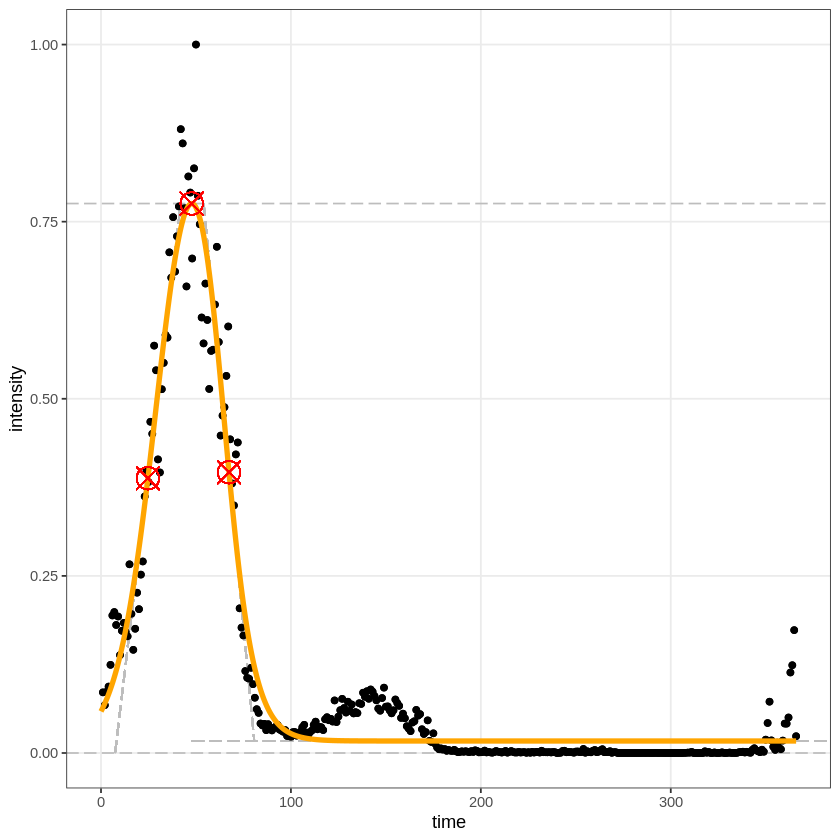

In [154]:
fit_curve <- function(x) {
  normalizedInput <- normalizeData(dataInput = x, 
                                   dataInputName = "doubleSigmoidalSample")
  # Fit double-sigmoidal model
  doubleSigmoidalModel <- multipleFitFunction(dataInput = normalizedInput,
                                              model = "doublesigmoidal",
                                              n_runs_min = 20,
                                              n_runs_max = 500,
                                              showDetails = FALSE)                                                
  # Calculate additional parameters
  doubleSigmoidalModel <- parameterCalculation(doubleSigmoidalModel)

  # Plotting the model
  plot <- figureModelCurves(dataInput = normalizedInput,
  doubleSigmoidalFitVector = doubleSigmoidalModel,
  showParameterRelatedLines = TRUE)

  # Table with parameters
  params <- parameterCalculation(doubleSigmoidalModel)
  params %<>% 
    mutate(across(everything(), as.character)) %>%
    pivot_longer(everything())

  return(list(plot, params))

}
fitted_curves <- map(pollen_sum_day, ~ fit_curve(.x))

# Display optimized for Jupyter Notebooks
i <- "ALNU24"
head(fitted_curves[[i]][[2]], 50)
tail(fitted_curves[[i]][[2]], 30)
fitted_curves[[i]][[1]]



In [ ]:
# This is the curve currently used in COSMO

